In [46]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [47]:
X =torch.arange(16,dtype = torch.float32).reshape(2, 8)
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  8.,  0.,  0., 14.],
        [ 0.,  0., 20.,  0.,  0.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [48]:
# 定义模型参数
num_inputs, num_outs , num_hiddens1, num_hiddens2 = 784, 10 ,256, 256

dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self, num_inputs , num_outs, num_hiddens1, num_hiddens2, is_train=True):
        super(Net ,self ).__init__()
        self.num_inputs = num_inputs
        self.training = is_train
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1 , self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)

        return out

In [49]:
net = Net(num_inputs, num_outs, num_hiddens1, num_hiddens2)

In [50]:
def evaluate_accuracy(net, data_iter):
    '''计算在特定数据集上的正确率'''
    
    if  isinstance(net, torch.nn.Module):
        net.eval()
     # 累加器
    
    metric = d2l.Accumulator(2)
      
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    '''训练一个迭代周期'''
    # 将模型设为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和， 训练准确度总和， 样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),d2l.accuracy(y_hat, y), y.numel() )
    #返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]
def train_ch3(net, train_iter, test_iter, loss, num_eopch, updater):
    '''训练模型'''
    anitmator = d2l.Animator(xlabel='epoch', xlim = [1, num_eopch], ylim = [0,1],
                         legend = ['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_eopch):
        train_metrics =  train_epoch_ch3(net,train_iter=train_iter,loss=loss,updater=updater)
        test_acc = evaluate_accuracy(net, test_iter)
        anitmator.add(epoch+1 , train_metrics   +(test_acc,)) #  拼接元组
    train_loss, train_acc = train_metrics
    print(train_loss)
    assert train_loss < 0.5, train_loss
    assert train_acc < 1 and train_acc >0.7 ,train_acc
    assert test_acc < 1 and test_acc > 0.7 , test_acc

0.3328005856831868


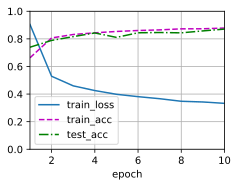

In [51]:
# 训练 和 测试
num_epochs, lr, batch_size  = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter,test_iter ,loss,num_epochs, trainer)

In [52]:
net= nn.Sequential(nn.Flatten(),
                   nn.Linear(num_inputs, num_hiddens1),
                   nn.ReLU(),
                   nn.Dropout(dropout1),
                   nn.Linear(num_hiddens1, num_hiddens2),
                   nn.ReLU(),
                   nn.Dropout(dropout2),
                   nn.Linear(num_hiddens2, num_outs)
                   )
def init_weights(m):
    if type(m) == nn.Module:
        nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

0.3329674053827922


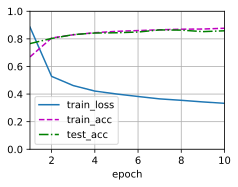

In [53]:
trainer = torch.optim.SGD(net.parameters(), lr)
train_ch3(net, train_iter, test_iter , loss, num_epochs,trainer)

1.5933638748168946


AssertionError: 1.5933638748168946

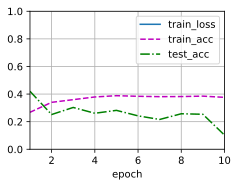

In [58]:

dropout1 , dropout= 0.95, 0.2 
net1 = Net(num_inputs, num_outs, num_hiddens1, num_hiddens2)
trainer1 = torch.optim.SGD(net1.parameters(), lr=lr)
train_ch3(net1, train_iter, test_iter , loss, num_epochs,trainer1)

1. 如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。

第一层 dropout更大，最终的 loss 会更大，当第一层为 0.95 时 无法收敛

![20250106105058](https://raw.githubusercontent.com/Rainbow452/image/main/img/20250106105058.png)










2.增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较。

0.20528757195472716


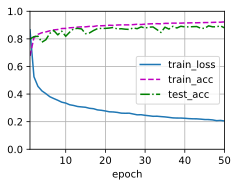

In [60]:
dropout1 , dropout= 0.2, 0.5
num_epochs = 50
net1 = Net(num_inputs, num_outs, num_hiddens1, num_hiddens2)
trainer1 = torch.optim.SGD(net1.parameters(), lr=lr)
train_ch3(net1, train_iter, test_iter , loss, num_epochs,trainer1)

0.3654130918820699


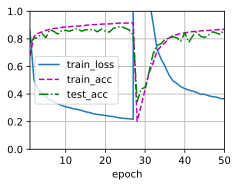

In [61]:
dropout1 , dropout= 0, 0
num_epochs = 50
net1 = Net(num_inputs, num_outs, num_hiddens1, num_hiddens2)
trainer1 = torch.optim.SGD(net1.parameters(), lr=lr)
train_ch3(net1, train_iter, test_iter , loss, num_epochs,trainer1)

3.当应用或不应用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。

In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs , num_outs, num_hiddens1, num_hiddens2, is_train=True):
        super(Net ,self ).__init__()
        self.num_inputs = num_inputs
        self.training = is_train
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1 , self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)

        return out ,  H1 , H2
    
def train_epoch_ch3(net, train_iter, loss, updater):
    '''训练一个迭代周期'''
    # 将模型设为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和， 训练准确度总和， 样本数
    metric = d2l.Accumulator(5)
    for X, y in train_iter:
        y_hat , H1, H2= net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),d2l.accuracy(y_hat, y), y.numel()  ,[ torch.var(h1) for h1 in H1])
    #返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]
def train_ch3(net, train_iter, test_iter, loss, num_eopch, updater):
    '''训练模型'''
    anitmator = d2l.Animator(xlabel='epoch', xlim = [1, num_eopch], ylim = [0,1],
                         legend = ['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_eopch):
        train_metrics =  train_epoch_ch3(net,train_iter=train_iter,loss=loss,updater=updater)
        test_acc = evaluate_accuracy(net, test_iter)
        anitmator.add(epoch+1 , train_metrics   +(test_acc,)) #  拼接元组
    train_loss, train_acc = train_metrics
    print(train_loss)
    assert train_loss < 0.5, train_loss
    assert train_acc < 1 and train_acc >0.7 ,train_acc
    assert test_acc < 1 and test_acc > 0.7 , test_acc

    
dropout1 , dropout= 0.2, 0.5
num_epochs = 50
net1 = Net(num_inputs, num_outs, num_hiddens1, num_hiddens2)
trainer1 = torch.optim.SGD(net1.parameters(), lr=lr)
train_ch3(net1, train_iter, test_iter , loss, num_epochs,trainer1)

In [ ]:
dropout1 , dropout= 0, 0
num_epochs = 50
net1 = Net(num_inputs, num_outs, num_hiddens1, num_hiddens2)
trainer1 = torch.optim.SGD(net1.parameters(), lr=lr)
train_ch3(net1, train_iter, test_iter , loss, num_epochs,trainer1)

4.为什么在测试时通常不使用暂退法？

5.以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

6.如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？


7.发明另一种用于在每一层注入随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发一种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的方法。